# Long-range erosion and deposition models

This notebook explores erosion and deposition mechanics for long-range transport by rivers. The incision rate in "stream power" form is,

$$
\frac{d h}{d t} = q_s = K q_r^m S^n
$$

where $q_r = \int_0^A R \, \mathrm{d}A$ is the accumulated run-off for all areas which lie upstream, $S$ is the slope, and $K$ is a proportionality constant which relates to the efficiency of the stream to transport sediment. $m$ and $n$ vary depend on the transport theory being used but $\frac{n}{m}=\frac{1}{2}$ is common.

We expore three transport models:

1. Local equilibrium
2. Saltation length (Beaumont _et al._ 1992, Kooi & Beaumont 1994, 1996)
3. $\xi-q$ model (Davy and Lague 2009)

In [1]:
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.05, 0.05

x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 50000, 1000)
# x, y = meshtools.lloyd_mesh_improvement(x, y, bmask, 5)
DM = meshtools.create_DMPlex_from_points(x, y, bmask)

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0


In [3]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.05, 0.05

x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 50000, 1000)
# x, y = meshtools.lloyd_mesh_improvement(x, y, bmask, 5)
DM = meshtools.create_DMPlex_from_points(x, y, bmask)

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0


In [53]:
height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001
height += np.random.random(height.size) * 0.0005 # random noise

rain = np.ones_like(sp.height)
rain[np.where(sp.height<0.98)]=0.0

sp = SurfaceProcessMesh(DM)
sp.update_height(height)
sp.update_surface_processes(rain, np.zeros_like(rain))

 - Delaunay triangulation 0.739264s
 - cKDTree 0.012007s
 - Calculate node weights and area 0.642465s
 - Compute edge lengths 0.082028s
 - Construct nearest neighbour array 0.295488s
 - Find boundaries 0.00975800000001s
 - Build smoothing matrix 0.01289s
 - Construct neighbour cloud array 0.194313s
 - Construct rbf weights 0.070111s
 - Sort nodes by field 0.087618s
 - Build downhill matrices 0.14715s
 - Upstream area 0.069549s


Each of the erosion-depositon models require the stream power...

In [54]:
def compute_stream_power(self, m=1, n=1):
    """
    Stream power law (q_s)
    """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain # / self.area
    stream_power = cumulative_flow_rate**m *self.slope**n
    return stream_power

stream_power = compute_stream_power(sp, m=1, n=1)

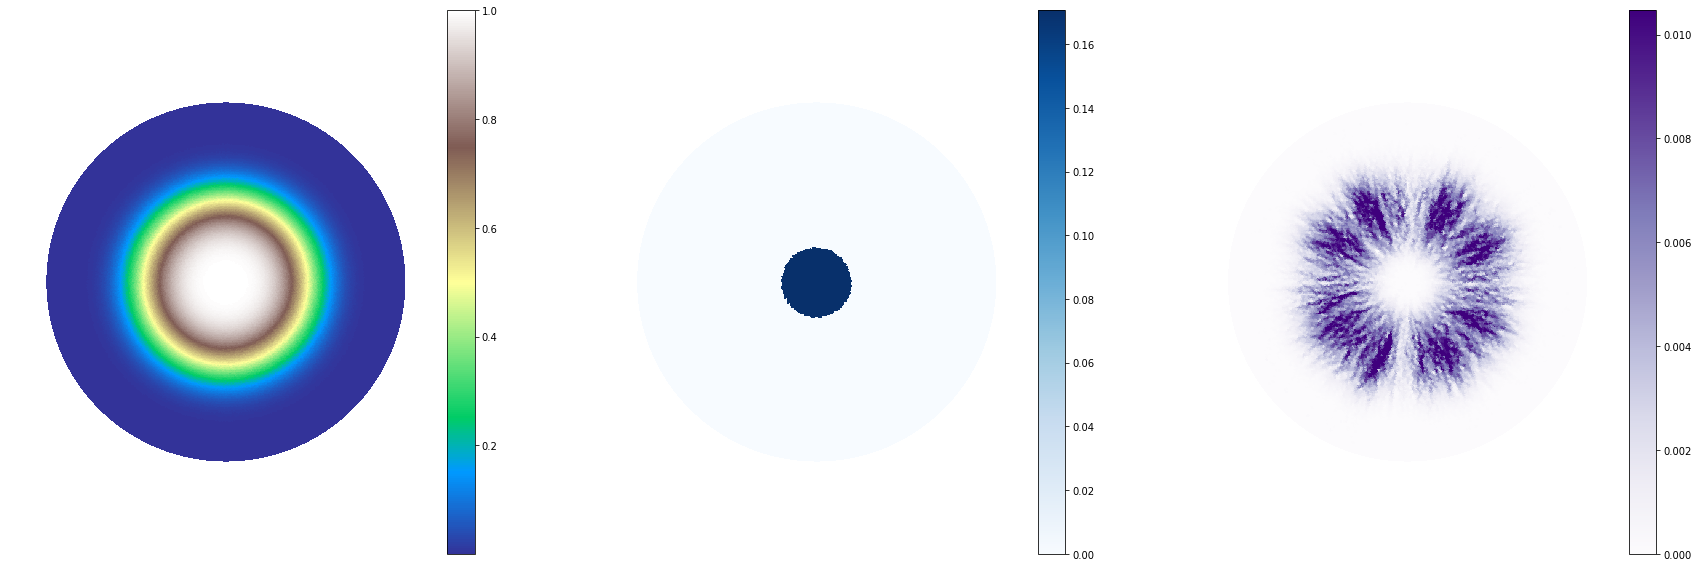

In [55]:
# Plot the height, rainfall, and stream power
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, height, cmap='terrain')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, rain, cmap='Blues', vmax=rain.mean()*5.0)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples', vmax=stream_power.mean()*5.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

## 1. Local equilibrium

The assumption of the stream power law is that sediment transport is in a state of local equilibrium in which the transport rate is equal to the local carrying capacity. If we neglect suspended-load transport for a moment and assume only bed-load transport then the local deposition is the amount of material that can be eroded from upstream.

In [56]:
def erosion_deposition_1(self, stream_power, efficiency=0.1):
    """
    Local equilibrium model
    """

    erosion_rate = efficiency*stream_power
    full_capacity_sediment_load = stream_power*self.area

    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    transport_limited_eroded_material = np.minimum(cumulative_eroded_material, full_capacity_sediment_load)

    excess = sp.gvec.duplicate()
    excess.setArray(cumulative_eroded_material - transport_limited_eroded_material)

    deposition = excess - self.downhillMat*excess
    deposition_rate = deposition.array / self.area

    return erosion_rate, deposition_rate

erosion_rate1, deposition_rate1 = erosion_deposition_1(sp, stream_power, efficiency=0.1)
depo_smooth  = sp.streamwise_smoothing(deposition_rate1, 3, centre_weight=0.5)



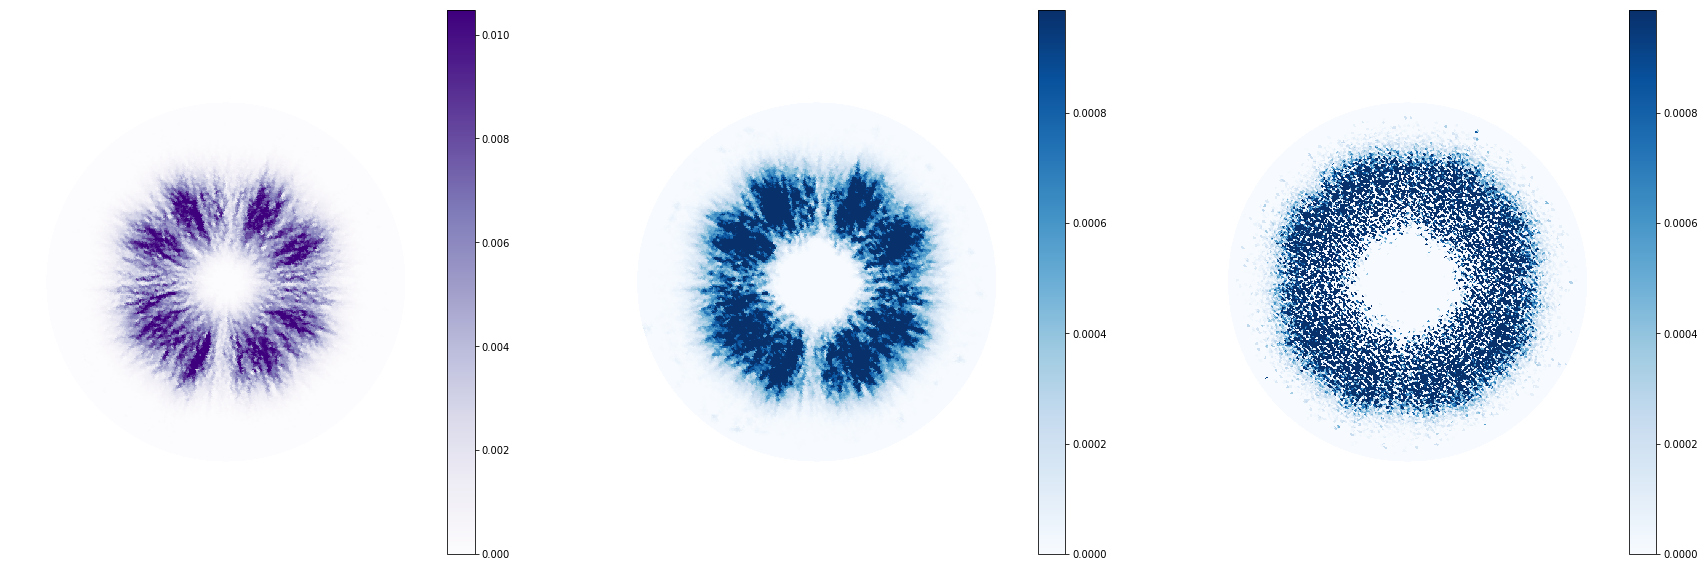

In [59]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples', vmax=stream_power.mean()*5.0)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, depo_smooth, cmap='Blues',   vmin=0, vmax=deposition_rate1.mean()*3.0)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate, cmap='Blues',vmin=0, vmax=deposition_rate1.mean()*3.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

## 2. Saltation length

This model relates the length of time it takes for a grain to settle to a material property, $L_s$.
From Beaumont et al. 1992, Kooi & Beaumont 1994, 1996 we see a linear dependency of deposition flux to stream capacity:

$$
\frac{dh}{dt} = \frac{dq_s}{dl} = \frac{D_c}{q_c} \left(q_c - q_s \right)
$$

where

$$
\frac{D_c}{q_c} = \frac{1}{L_s}
$$

$D_c$ is the detachment capacity, $q_c$ is the carrying capacity, $q_s$ is the stream capacity, and $L_s$ is the erosion length scale (a measure of the detachability of the substrate). When the flux equals capacity, $q_c = q_s$, no erosion is possible.

In [ ]:
def erosion_deposition_2(self, stream_power, efficiency=0.1, length_scale=10.):
    """
    Saltation length from Beaumont et al. 1992
    """
    
    erosion_rate = efficiency*stream_power
    
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    cumulative_deposition_rate = cumulative_eroded_material / self.area
    
    erosion_deposition = 1.0/length_scale * (cumulative_deposition_rate - erosion_rate)
    return erosion_rate, erosion_deposition

erosion_rate2, deposition_rate2 = erosion_deposition_2(sp, stream_power, efficiency=0.1, length_scale=10.)

In [ ]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples', vmax=stream_power.mean()*5.0)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, erosion_rate2, cmap='Reds', vmax=erosion_rate2.mean()*5.0)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate2, cmap='Blues', vmax=deposition_rate2.mean()*5.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

## 3. $\xi - q$ model

Davy and Lague (2009) propose a similar suspended-load model that encapsulates a range of behaviours between detachment and transport-limited end members. This model couples erodability as a function of stream power with a sedimentation term weighted by $\alpha$.

$$
\frac{dh}{dt} = -K q_r^m S^n + \frac{Q_s}{\alpha Q_w}
$$

where $Q_s$ and $Q_w$ are the sedimentary and water discharge, respectively.

In [ ]:
def erosion_depositon_3(self, stream_power, efficiency=0.1, alpha=1.):
    """
    xi - q model from Davy and Lague 2009
    """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain # / self.area
    erosion_rate = efficiency*stream_power
    
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    cumulative_deposition_rate = cumulative_eroded_material / self.area
    
    deposition_rate = self.area * cumulative_deposition_rate / (alpha * cumulative_flow_rate )

    return erosion_rate, deposition_rate

erosion_rate3, deposition_rate3 = erosion_depositon_3(sp, stream_power, efficiency=0.1, alpha=1.0)

In [ ]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples', vmax=stream_power.mean()*5.0)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, erosion_rate3, cmap='Reds', vmax=erosion_rate3.mean()*5.0)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate3, cmap='Blues', vmax=deposition_rate3.mean()*5.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

A comparison of deposition rates calculated from each model...

In [ ]:
# Compare deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, deposition_rate1, cmap='Blues', vmin=0, vmax=.005)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, deposition_rate2, cmap='Blues', vmin=0, vmax=.005)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate3, cmap='Blues', vmin=0, vmax=.005)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()